In this post, we introduce [Mesa](https://github.com/projectmesa/mesa) a library written in Python3 for Agent-Based Modeling (ABM). [Agent-based modeling](https://en.wikipedia.org/wiki/Agent-based_model) is a growing topic of interest in many scientific disciplines, due to its flexibility for modeling complex dynamical systems. Agent-based models (ABMs) consist of autnomous, interacting computational objets, called agents within a given environment.

In this post, we introduce the components of of Mesa through a simple foraging model. In this model, a forager (a bug) walks around, searching for foods. We have three different kind of food resources: bean, corn and soy. Foods differ from their growth rate, density on the landscape, and thier starting energy level.

Without further ado, we specify the components of our foraging model.

### Environment

One of the component of an ABM system is the *Environment*. The environment is where global variables are set up and managed like the number of agents, the scheduler, or the space where the simulation takes place. In Mesa, the environment is handle by a the `Model` class. This class takes a seed keyword. We inherit that class to create our own environment.

First of all, we create the directory where the srcipts of our model will be saved. At the console:

```bash
$ mkdir foraging
```

or in the notebook

In [ ]:
!mkdir foraging

We add our first file which is just a directive for Python to treat this directory as a package.

In [1]:
%%writefile foraging/__init__.py

UsageError: %%writefile is a cell magic, but the cell body is empty.


In [2]:
%%writefile foraging/model.py
from mesa.model import Model

class Foraging(Model):
    
    number_of_bean = 0
    number_of_corn = 0
    number_of_soy = 0
    
    def __init__(self, num_bug=50, seed=42, strategy=None):
        super().__init__(seed=seed)
        self.number_of_bug = num_bug
        if not(strategy in ["stick", "switch"]):
            raise TypeError("'strategy' must be one of {stick, switch}")
        self.strategy = strategy

Overwriting foraging/model.py


The environment defines the *space* where the agents evolve. The space range from simple square grid to complex geospatial space. In this post, the agents evolve within a simple square grid where each colored cell indicades the presence of an agent and the color indicates the type of agent (we will come to that later). We add the space in our environment.

In [3]:
%%writefile foraging/model.py
from mesa.model import Model
from mesa.space import SingleGrid

class Foraging(Model):
    
    number_of_bean = 0
    number_of_corn = 0
    number_of_soy = 0
    
    def __init__(self, width=50, height=50, torus=True, num_bug=50, seed=42, strategy=None):
        super().__init__(seed=seed)
        self.number_of_bug = num_bug
        if not(strategy in ["stick", "switch"]):
            raise TypeError("'strategy' must be one of {stick, switch}")
        self.strategy = strategy
        
        sefl.grid = SingleGrid(width, height, torus)

Overwriting foraging/model.py


The environment also defines a *scheduler* that manages the agents at every time step. The choice of the type of scheduler is very important since it specifies how (in which order) the state of the agents is updated. In this post, we use a random scheduler. It means that at every time step, agents are choose at random at thier state is updated.

In [4]:
%%writefile foraging/model.py
from mesa.model import Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation

class Foraging(Model):
    
    number_of_bean = 0
    number_of_corn = 0
    number_of_soy = 0
    
    def __init__(self, width=50, height=50, torus=True, num_bug=50, seed=42, strategy=None):
        super().__init__(seed=seed)
        self.number_of_bug = num_bug
        if not(strategy in ["stick", "switch"]):
            raise TypeError("'strategy' must be one of {stick, switch}")
        self.strategy = strategy
        
        self.grid = SingleGrid(width, height, torus)
        self.schedule = RandomActivation(self)

Overwriting foraging/model.py


Since the purpose of an ABM is to study the behaviour of a system under different conditions, we need a way to collect the relevant data of the system while it is running. The relevent data in this example being the number of food resources (bean, corn, soy) and the number of foragers (bug) at each time step. This is handle in Mesa with the `DataCollector` class.

In [5]:
%%writefile foraging/model.py
from mesa.model import Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class Foraging(Model):
    
    number_of_bean = 0
    number_of_corn = 0
    number_of_soy = 0
    
    def __init__(self, width=50, height=50, torus=True, num_bug=50, seed=42, strategy=None):
        super().__init__(seed=seed)
        self.number_of_bug = num_bug
        if not(strategy in ["stick", "switch"]):
            raise TypeError("'strategy' must be one of {stick, switch}")
        self.strategy = strategy
        
        self.grid = SingleGrid(width, height, torus)
        self.schedule = RandomActivation(self)
        data = {"Bean": lambda m: m.number_of_bean,
                "Corn": lambda m: m.number_of_corn,
                "Soy": lambda m: m.number_of_soy,
                "Bug": lambda m: m.number_of_bug,
                }
        self.datacollector = DataCollector(data)
    
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        
        if not(self.grid.exists_empty_cells()):
            self.running = False

Overwriting foraging/model.py


The `step` method of the environment run the model by calling the `step` method of the scheduler which in turn call the `step` method of every agent which is where the behaviour of the agent is defined.

### Agents

**Food**

On of the agent in this example is the food resource. In this section, we describe the behaiour of a food resource. 

A food resource starts with a fixed ernergy and grows at a fixed rate. When the resource is fully frown, it starts to wilt at fixed wilt rate. If the food is fully grown and its energy reachs a certain treshold, the food replicate itself in an empty cell in the neighborhood if there is one, otherwise, nothing is done. If a food has no more energy, it is removed from the environemnt.

In [6]:
%%writefile foraging/resources.py
import random

from mesa.agent import Agent

class Food(Agent):
    
    fully_grown = False
    
    def __init__(self, unique_id, model, pos=None):
        super().__init__(unique_id, model)
        self.pos = pos
    
    def step(self):
        if self.fully_grown:
            self.energy -= self.wilt_rate
        else:
            self.energy += self.growth_rate
        
        if self.energy >= self.max_growth:
            self.fully_grown = True
        
        # new Food
        if self.fully_grown and (self.energy >= self.max_growth):
            neig = self.model.grid.get_neighborhood(self.pos, True, False)
            is_empty = self.model.grid.is_cell_empty
            
            if any(map(is_empty, neig)):
                empty = list(filter(is_empty, neig))
                pos = random.choice(empty)
                food_name = type(self).__name__.lower()
                attr_name = "number_of_{}".format(food_name)
                last = getattr(self.model, attr_name)
                new_food = type(self)(last + 1, self.model)
                self.energy -= new_food.energy
                setattr(self.model, attr_name, last + 1)
                self.model.grid.place_agent(new_food, pos)
                self.model.schedule.add(new_food)
        
        # Death
        if self.energy <= 0:
            food_name = type(self).__name__.lower()
            attr_name = "number_of_{}".format(food_name)
            last = getattr(self.model, attr_name)
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
            setattr(self.model, attr_name, last - 1)

Overwriting foraging/resources.py


**Forager**

In this section, we describe the behavior of the forager (bug) in this example.

Each forager borns with a fixed amount of energy, searches for foods in its neighborhood and moves according to the given strategy (describe below). When a forager moves, its energy decrease proportionally to the distance between its current position and the targeted position. When a forager gets old, its energy decreases by a fixed amount. If a forager is adult (is at a certain age), and its energy level is above a certain threshold, the forager gives birth in an empty cell in the neighborhood if there is one, otherwise, moves to a random empty cell eslsewhere if possible. If a forager has no more energy, it dies (i.e. it's removed from the environment).

In the follwing, is the description of each strategy.

- **Stick**: In this strategy, a forager moves to a random location if there is nothing around him (no neighbors). Otherwise, stay at its current location.

- **Switch**: In this strategy, at each time step, a forager moves to an empty location in its neighborhood if there is one, otherwise stay at ist current location.

In [7]:
%%writefile foraging/agents.py
import random

from mesa.agent import Agent

from foraging.utils import euclidean
from foraging.resources import Food

class Bug(Agent):
    
    treshold = 15
    metabolism = 1
    energy = 10
    strategy = None
    age = 0
    
    def __init__(self, unique_id, model, pos=None):
        super().__init__(unique_id, model)
        self.pos = pos
        self.move = {"stick": self.stick,
                     "switch": self.switch,
                    }
    
    def step(self):
        self.age += 1
        
        adult = self.age > 5
        old = self.age > 50
        
        if old:
            self.energy -= self.metabolism
        
        self.find_food()
        self.move[self.strategy]()
        
        # new Bug
        has_energy = self.energy >= self.treshold
        if has_energy and (adult):
            neig = self.model.grid.get_neighborhood(self.pos, True, False)
            
            if any(map(self.model.grid.is_cell_empty, neig)):
                empty = list(filter(self.model.grid.is_cell_empty, neig))
                pos = random.choice(empty)
                last = self.model.number_of_bug
                new_bug = Bug(last + 1, self.model)
                new_bug.strategy = self.strategy
                self.energy -= new_bug.energy
                self.model.grid.place_agent(new_bug, pos)
                self.model.schedule.add(new_bug)
                self.model.number_of_bug += 1
            else:
                pos = self.model.grid.find_empty()
                self.move_to(pos)
        
        # Death
        if self.energy <= 0:
            self.die()
    
    def switch(self):  
        neig = self.model.grid.get_neighborhood(self.pos, True, False)
        pos = random.choice(neig)
        if self.model.grid.is_cell_empty(pos):
            self.move_to(pos)
    
    def stick(self):
        neig = self.model.grid.get_neighbors(self.pos, True)
        if not(neig):
            pos = self.model.grid.find_empty()
            self.move_to(pos)
    
    def move_to(self, pos):
        distance = round(euclidean(self.pos, pos))
        cost = self.metabolism * distance
        
        self.model.grid.move_agent(self, pos)
        self.energy -= cost
    
    def find_food(self):
        neig = self.model.grid.get_neighbors(self.pos, True, False)
        if neig:
            agent = random.choice(neig)
            if isinstance(agent, Food):
                self.eat(agent)
    
    def eat(self, food):
        gain = self.age * self.metabolism
        self.energy += gain
        food.energy -= gain
    
    def die(self):
        self.model.grid._remove_agent(self.pos, self)
        self.model.schedule.remove(self)
        self.model.number_of_bug -= 1

class Bean(Food):
    
    density = 0.005
    growth_rate = 4
    wilt_rate = 2
    max_growth = 20
    energy = 4

class Corn(Food):
    
    density = 0.01
    growth_rate = 2
    wilt_rate = 1
    max_growth = 10
    energy = 2

class Soy(Food):
    
    density = 0.001
    growth_rate = 20
    wilt_rate = 10
    max_growth = 100
    energy = 20

Overwriting foraging/agents.py


We can now finish to implement our envionment class with the methods to populate agents.

In [8]:
%%writefile foraging/model.py
from mesa.model import Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

from foraging.agents import Bean, Corn, Soy, Bug

class Foraging(Model):
    
    number_of_bean = 0
    number_of_corn = 0
    number_of_soy = 0
    
    def __init__(self, width=50, height=50, torus=True, num_bug=50, seed=42, strategy=None):
        super().__init__(seed=seed)
        self.number_of_bug = num_bug
        if not(strategy in ["stick", "switch"]):
            raise TypeError("'strategy' must be one of {stick, switch}")
        self.strategy = strategy
        
        self.grid = SingleGrid(width, height, torus)
        self.schedule = RandomActivation(self)
        data = {"Bean": lambda m: m.number_of_bean,
                "Corn": lambda m: m.number_of_corn,
                "Soy": lambda m: m.number_of_soy,
                "Bug": lambda m: m.number_of_bug,
                }
        self.datacollector = DataCollector(data)
        
        # create foods
        self._populate(Bean)
        self._populate(Corn)
        self._populate(Soy)
        
        # create bugs
        for i in range(self.number_of_bug):
            pos = self.grid.find_empty()
            bug = Bug(i, self)
            bug.strategy = self.strategy
            self.grid.place_agent(bug, pos)
            self.schedule.add(bug)
    
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        
        if not(self.grid.exists_empty_cells()):
            self.running = False
    
    def _populate(self, food_type):
        prefix = "number_of_{}"
        
        counter = 0
        while counter < food_type.density * (self.grid.width * self.grid.height):
            pos = self.grid.find_empty()
            food = food_type(counter, self)
            self.grid.place_agent(food, pos)
            self.schedule.add(food)
            food_name = food_type.__name__.lower()
            attr_name = prefix.format(food_name)
            val = getattr(self, attr_name)
            val += 1
            setattr(self, attr_name, val)
            counter += 1

Overwriting foraging/model.py


With all this, we can run our model and examine the results. The way we run a model with different staring point in Mesa is trough the `BactchRunner` class which take a model constructor and a dictionnary of the different parameters to run the model with. But in this post, we will manually run the model and collect the result.

In [9]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from foraging.model import Foraging

time = 250

def show(result, stragegy):
    
    with plt.style.context("fivethirtyeight"):
        ax = result.plot(kind="line", figsize=(8,5))
        ax.set_xlabel("Run")
        ax.set_ylabel("Population size")
        ax.set_title("Evolution of bug's population with '{}' strategy".format(strategy))

def run(time, **kwargs):
    
    result = {"Bean": [], "Corn": [], "Soy": [], "Bug": []}
    model = Foraging(**kwargs)
    
    progress = tqdm_notebook(total=time)
    for t in range(time):
        model.step()
        result["Bean"].append(model.number_of_bean)
        result["Corn"].append(model.number_of_corn)
        result["Soy"].append(model.number_of_soy)
        result["Bug"].append(model.number_of_bug)
        
        progress.update()
        
    progress.close()
    
    return pd.DataFrame(result)

In [10]:
strategy = "stick"
result = run(time, strategy=strategy)

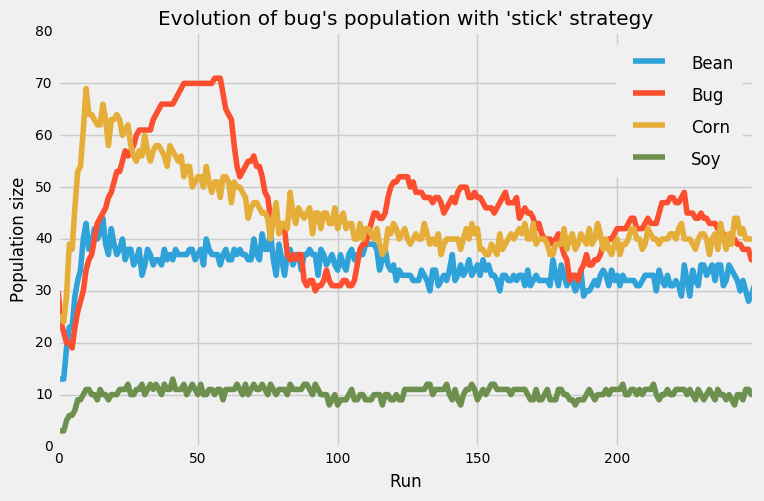

In [11]:
show(result, strategy)

In [12]:
strategy = "switch"
result = run(time, strategy=strategy)

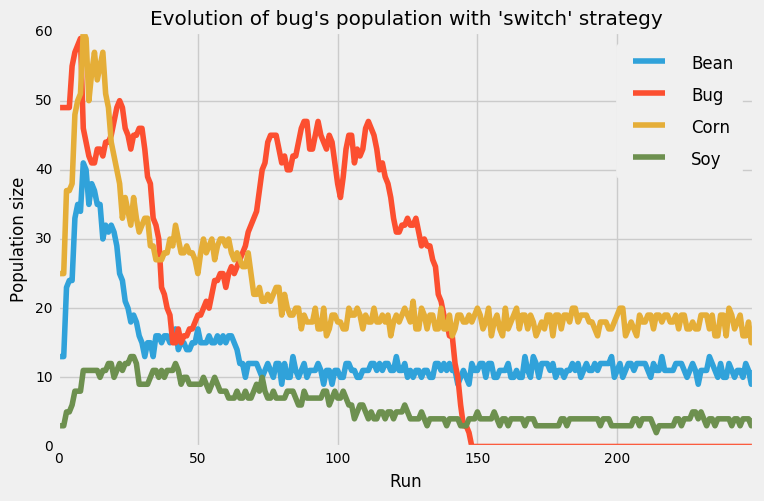

In [13]:
show(result, strategy)

Mesa has an in-browser visualization feature that allows the user to see the model at running in the browser. To use that functionality in our example, we add what follows in our directory.

In [14]:
%%writefile foraging/server.py
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer

from foraging.agents import Bean, Corn, Soy, Bug
from foraging.model import Foraging

width = 50
height = 50

def food_portrayal(agent):
    
    if agent is None:
        return
    
    portrayal = {"Shape": "rect", "Filled": "true", "w": 0.8, "h": 0.8, "Layer": 0}
    
    if type(agent) is Bean:
        portrayal["Color"] = "cornflowerblue"
    
    elif type(agent) is Corn:
        portrayal["Color"] = "blueviolet"
    
    elif type(agent) is Soy:
        portrayal["Color"] = "forestgreen"
    
    elif type(agent) is Bug:
        portrayal["Shape"] = "circle"
        portrayal["Color"] = "tomato"
        portrayal["r"] = 1
        portrayal["Layer"] = 1
    
    return portrayal

bean = {"Label": "Bean", "Color": "cornflowerblue"}
corn = {"Label": "Corn", "Color": "blueviolet"}
soy = {"Label": "Soy", "Color": "forestgreen"}
bug = {"Label": "Bug", "Color": "tomato"}

canvas = CanvasGrid(food_portrayal, width, height)
chart_count = ChartModule([bean, corn, soy, bug])

server = ModularServer(Foraging, [canvas, chart_count], name="Foraging", strategy="stick")

server.launch()

Overwriting foraging/server.py


Once added, we launch the model at the console like this:

```bash
$ python3 foraging/server.py
```

or in the notebook.

In [ ]:
%run foraging/server.py

When launch, something like the figure below opens up in your browser and you can press the run button to run the model.

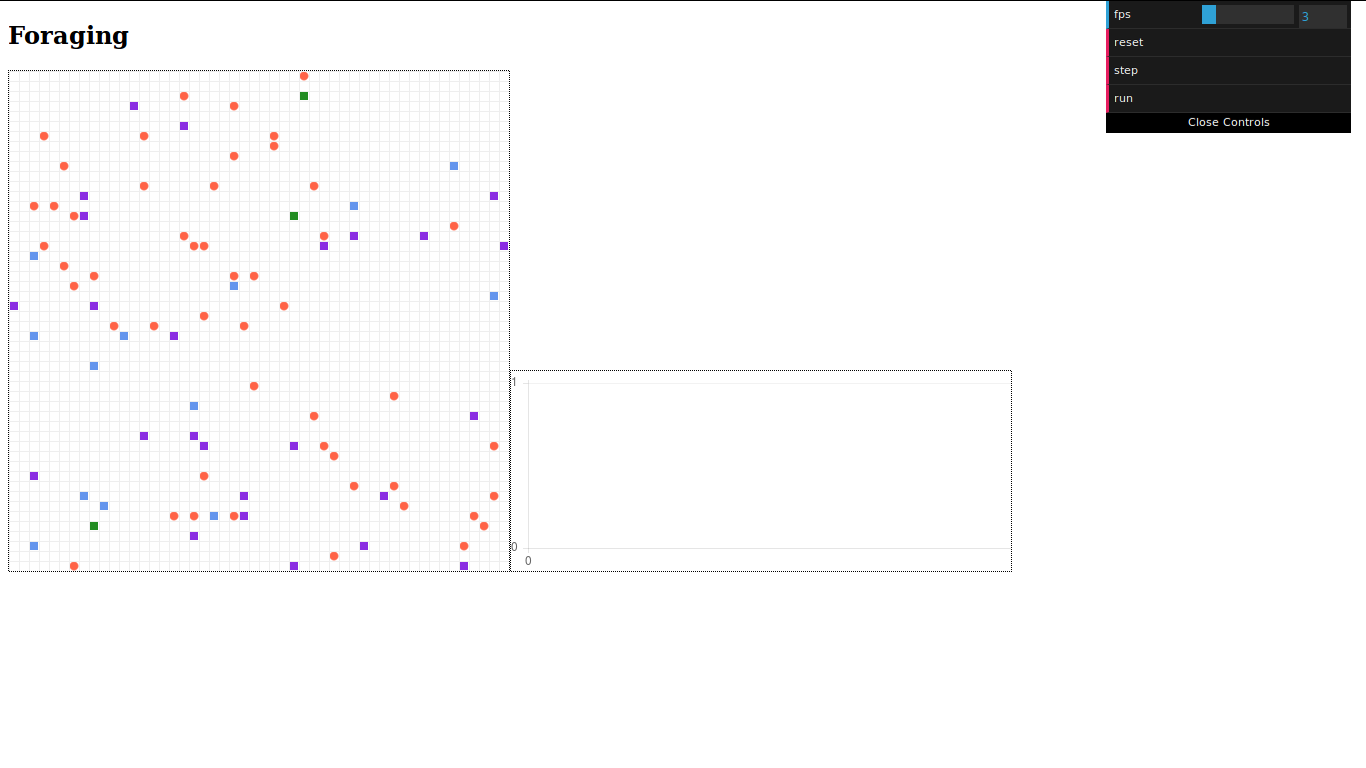

In [15]:
from IPython.display import Image

Image("images/foraging.png")

## Conclusion

In this post, we introduce Mesa, an agent-based modeling framework through a simple foraging model. Mesa is still in its infancy but in the near future, itends to have the power of a full featured ABM's framework. To have an idea of what is coming next, you can watch this [presentation](https://www.youtube.com/watch?v=bjjoHji8KUQ) by [Jackie](https://twitter.com/JackieKazil) at PyDataDC 2016.

### Futher reading

David Masad, Jacqueline Kazil: Mesa: An Agent-Based Modeling Framework. *Proc. of the 14th Python in Science Conf*. 2015

Scott de Marchi and Scott E. Page: Agent-Based Models. *Annual Review of Polotical Science Vol 17: 1-20*. 2014

A Lee: [Introduction to Agent Based Modeling](https://www.gitbook.com/book/cbie/introduction-to-agent-based-modeling/details).